In [ ]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train=pd.read_json('/content/1625753757820.json')

In [ ]:
df = pd.DataFrame()
df['c1']=train['data']['channel1']
df['time']=range(len(train['data']['channel1']))
#df['time'] = pd.to_datetime(df['time'])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'], y=df['c1'], name='vibration'))
fig.update_layout(showlegend=True, title='Vibration Channel1 ')
fig.show()

In [ ]:
df.shape

(16384, 2)

In [ ]:
train, test = df.loc[df['time'] <= 14000], df.loc[df['time'] > 14000]
train.shape, test.shape

((14001, 2), (2383, 2))

In [ ]:

scaler = StandardScaler()
scaler = scaler.fit(train[['c1']])

train['c1'] = scaler.transform(train[['c1']])
test['c1'] = scaler.transform(test[['c1']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [ ]:
TIME_STEPS=50

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['c1']], train['c1'])
X_test, y_test = create_sequences(test[['c1']], test['c1'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (13951, 50, 1)
Testing shape: (2333, 50, 1)


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 50, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
393/393 [==============================] - 44s 104ms/step - loss: 0.3255 - val_loss: 0.2148
Epoch 2/100
393/393 [==============================] - 40s 102ms/step - loss: 0.2265 - val_loss: 0.1708
Epoch 3/100
393/393 [==============================] - 40s 103ms/step - loss: 0.2040 - val_loss: 0.1750
Epoch 4/100
393/393 [==============================] - 41s 103ms/step - loss: 0.1830 - val_loss: 0.1675
Epoch 5/100
393/393 [==============================] - 40s 103ms/step - loss: 0.1780 - val_loss: 0.1536
Epoch 6/100
393/393 [==============================] - 40s 102ms/step - loss: 0.1783 - val_loss: 0.1543
Epoch 7/100
393/393 [==============================] - 40s 103ms/step - loss: 0.1792 - val_loss: 0.1689
Epoch 8/100
393/393 [==============================] - 40s 103ms/step - loss: 0.1738 - val_loss: 0.1531
Epoch 9/100
393/393 [==============================] - 40s 102ms/step - loss: 0.1856 - val_loss: 0.1559
Epoch 10/100
393/393 [==============================] - 40s 102m

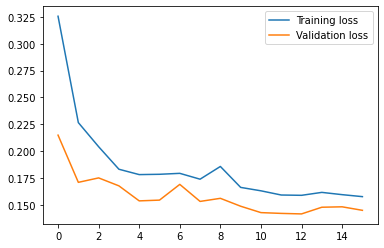

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

73/73 [==============================] - 2s 30ms/step - loss: 0.1472


0.1471800059080124

In [ ]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

Reconstruction error threshold: 2.5394070564702966


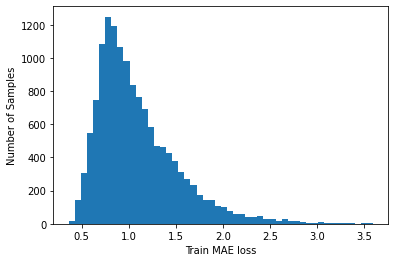

In [ ]:
 

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.quantile(train_mae_loss,0.99)
print(f'Reconstruction error threshold: {threshold}')

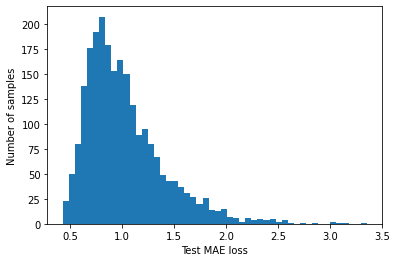

In [ ]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['c1'] = test[TIME_STEPS:]['c1']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['time'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['time'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(12, 5)

In [ ]:
gig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['time'], y=scaler.inverse_transform(test_score_df['c1']), name='Vibration'))
fig.add_trace(go.Scatter(x=anomalies['time'], y=scaler.inverse_transform(anomalies['c1']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()